In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Define strings so that files can be opened in a loop

str0 = 'CESM2_LE_Data/Historical/'
str1 = '/b.e21.BHIST'
cmip6_str = 'cmip6'
smbb_str = 'smbb'
str2 = '.f09_g17.LE2-'
str3 = '.0'
str4 = '.cam.h0.RELHUM.1850-2014_'
str5 = '.nc'

str_EP = 'East_Pacific_Mean'
str_EP2 = 'EP_mean'

str_trop = 'Tropical_Mean'
str_trop2 = 'tropical_mean'

str_zon = 'Zonal_Mean'
str_zon2 = 'zonal_mean'

season_strs = ['DJF_', 'MAM_', 'JJA_', 'SON_']

In [4]:
ens_nos = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
           '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

ensembles = ens_nos[:10] + ens_nos[:10] + ens_nos[:10] + ens_nos[:10] + ens_nos[:10] + ens_nos[:10] + ens_nos[10:20] + ens_nos[10:20] + ens_nos[10:20] + ens_nos[10:20]

In [5]:
brn_yrs = ['1001', '1021', '1041', '1061', '1081', '1101', '1121', '1141', '1161', '1181',
           '1011', '1031', '1051', '1071', '1091', '1111', '1131', '1151', '1171', '1191',
           '1231', '1251', '1281', '1301']

branch_years = brn_yrs[0:10]

for j in range(4):
    for i in range(10):
        branch_years = branch_years + [brn_yrs[20+j]]
        
branch_years = branch_years + brn_yrs[10:20]

for j in range(4):
    for i in range(10):
        branch_years = branch_years + [brn_yrs[20+j]]

In [6]:
# Define trend function that calculates the decadal trend in a dataset for 1 or 2-dimensional data.

def calc_trend(dat_xr, percentage_change=False, lat=True):
    
    year_start = dat_xr.groupby('time.year').mean().year.data[0]
    year_end = dat_xr.groupby('time.year').mean().year.data[-1]
    
    t = np.arange(year_start, year_end+1)
    trend_years = year_end+1-year_start
    
    # For 2D data with latitude coordinates, set lat equal to True
    if lat == True:
    
        trend = np.zeros((len(dat_xr.lat), len(dat_xr.lev)))
        for i in range(len(dat_xr.lat)):
            for j in range(len(dat_xr.lev)):
                x = dat_xr.isel(lat=i, lev=j)


                # Check if there are any NaNs, if there are then plot NaN
                if np.isnan(x.data[0]):
                    trend[i,j] = np.nan

                elif np.isnan(np.max(x.data)):
                    trend[i,j] = np.nan

                else:
                    # Find the linear trend of the data using polyfit
                    z = np.polyfit(t, x, 1)
                    p = np.poly1d(z)


                    if percentage_change == False:
                        # The trend is given by subtracting the last p(t) value from the first and dividing 
                        trend[i,j] = (p(t)[-1] - p(t)[0]) / trend_years * 10      
                    else:
                        # To expressing in terms of percentage change per period, use this equation
                        trend[i,j] = ((1 + ((p(t)[-1] - p(t)[0]) / p(t)[0])) ** (1/trend_years) *10 - 1) * 100

        # Create an array of the trend and plot
        trend_array = xr.DataArray(trend, dims=['lat', 'lev'], coords=dict(latitude=(dat_xr.lat),
                                    level=(dat_xr.lev))) 
    
    # For 1D data with only pressure levels
    else:
        
        trend = np.zeros(len(dat_xr.lev))
        for j in range(len(dat_xr.lev)):
            x = dat_xr.isel(lev=j)


            # Check if there are any NaNs, if there are then plot NaN
            if np.isnan(x.data[0]):
                trend[j] = np.nan

            elif np.isnan(np.max(x.data)):
                trend[j] = np.nan

            else:
                # Find the linear trend of the data using polyfit
                z = np.polyfit(t, x, 1)
                p = np.poly1d(z)


                if percentage_change == False:
                    # The trend is given by subtracting the last p(t) value from the first and dividing 
                    trend[j] = (p(t)[-1] - p(t)[0]) / trend_years * 10      
                else:
                    # To expressing in terms of percentage change per period, use this equation
                    trend[j] = ((1 + ((p(t)[-1] - p(t)[0]) / p(t)[0])) ** (1/trend_years) *10 - 1) * 100

        # Create an array of the trend and plot
        trend_array = xr.DataArray(trend, dims=['lev'], coords=dict(level=(dat_xr.lev))) 
        
    return trend_array
    


In [22]:
# Open the first ensemble to see how long each dimension is
RH_data_ex = calc_trend(xr.open_dataset(str0 + str_zon + str1 + cmip6_str + str2 + branch_years[0] + 
                                str3 + ensembles[0] + str4 + str_zon2 + str5)['RELHUM'])

# Zonal Mean

## Annual Mean

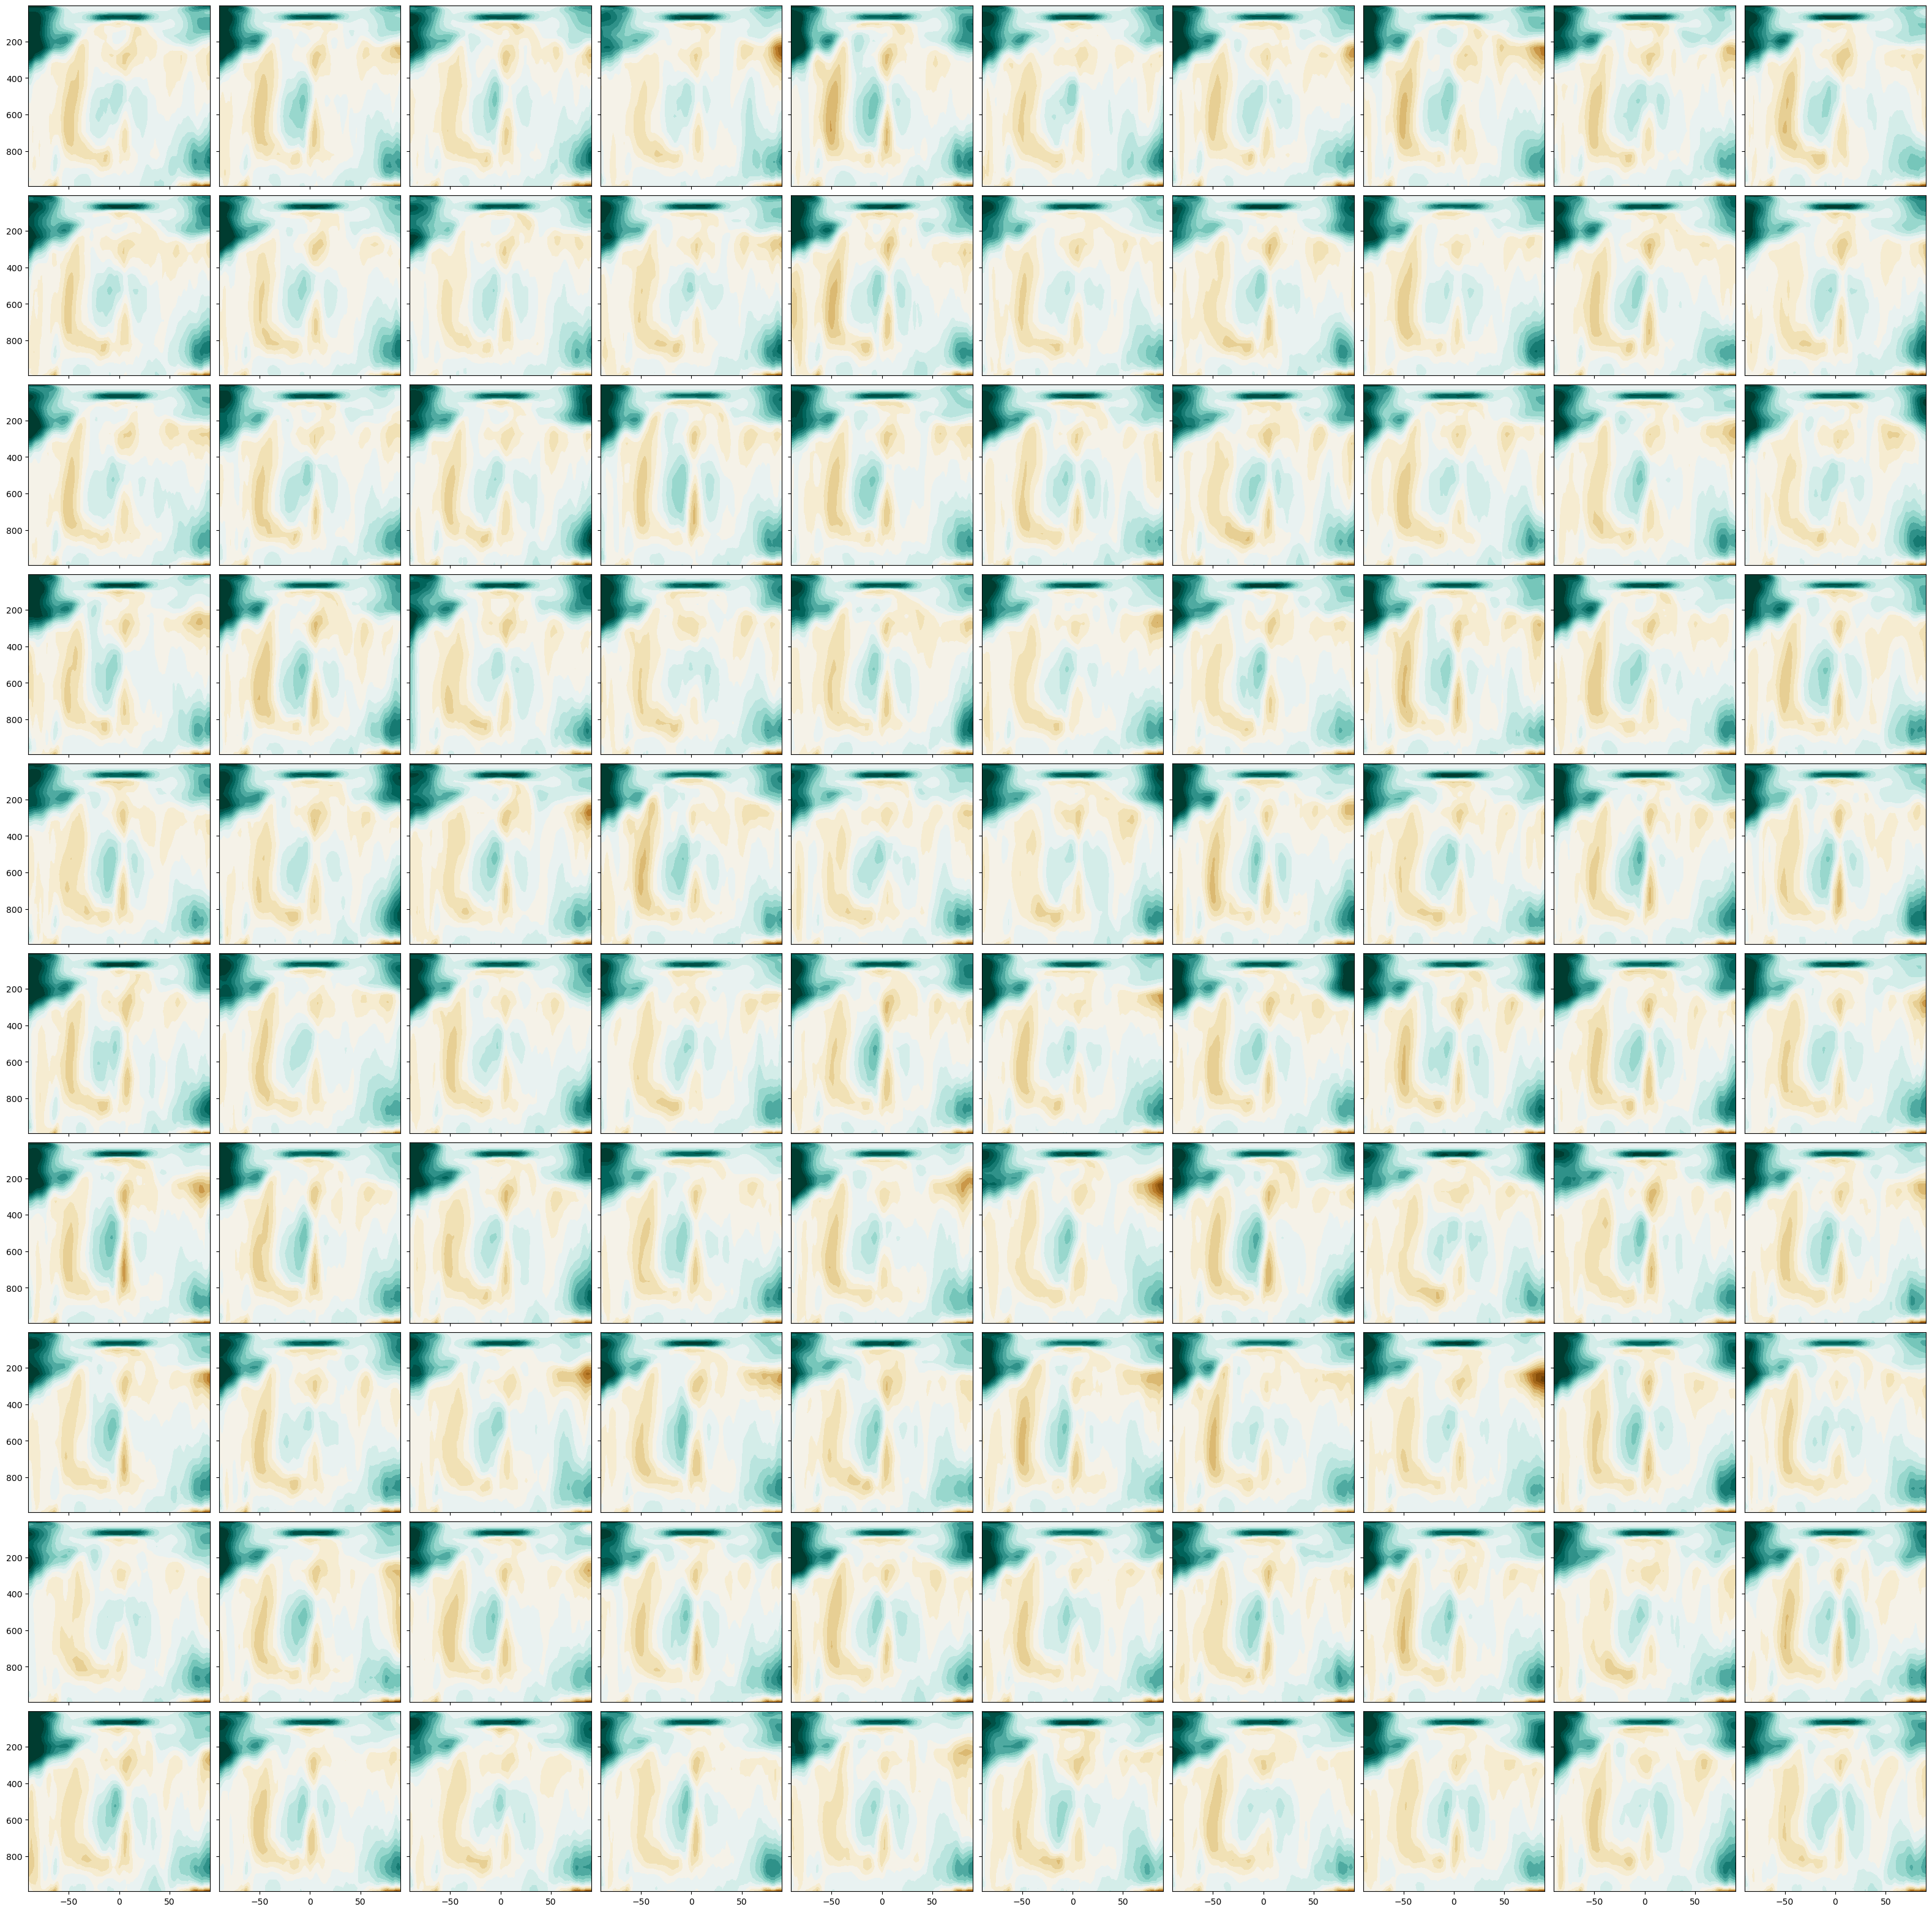

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [23]:
fig, axs = plt.subplots(10,10, figsize=(40,40), sharex='col', sharey='row')

# Predefine a data array to store the trend output for each ensemble
zonal_RH_annual_trend_all = xr.DataArray(dims=['latitude', 'level', 'ensemble'], coords=dict(latitude=RH_data_ex.latitude.data, 
                            level=RH_data_ex.level.data, ensemble=np.arange(1,101)))

# Run over all 100 ensembles
for i in range(len(ensembles)):    
    if i < 50:
        model_str = cmip6_str
    else:
        model_str = smbb_str

    # Open the RH data for a given ensemble
    zonal_RH_annual = xr.open_dataset(str0 + str_zon + str1 + model_str + str2 + branch_years[i] + 
                                str3 + ensembles[i] + str4 + str_zon2 + str5)['RELHUM']
    
    # Check that the data has been downloaded properly - there should be 165 years of data
    if len(zonal_RH_annual.time) == 165:
    
        # Calculate the annual RH trend
        zonal_RH_annual_trend = calc_trend(zonal_RH_annual)

        # Plot snapshots of all 100 ensembles
        c = zonal_RH_annual_trend.plot.contourf(ax=axs[int(np.floor(i/10)),i%10], x='latitude', y='level', add_colorbar=False, 
                                           levels=np.linspace(-0.3,0.3,21), extend='both', cmap='BrBG')
    
        # Store the data in the predefined array so the mean and standard deviation can be found
        zonal_RH_annual_trend_all[:,:,i] = zonal_RH_annual_trend.data
        
    else:
        print(model_str + str2 + branch_years[i] + str3 + ensembles[i])
            
    plt.subplots_adjust(hspace=0.05)
    plt.subplots_adjust(wspace=0.05)


    axs[int(np.floor(i/10)),i%10].set_ylabel('')
    axs[int(np.floor(i/10)),i%10].set_xlabel('')
    axs[int(np.floor(i/10)),i%10].invert_yaxis()

plt.show()
plt.close
    

In [24]:
# Calculate the mean and standard deviation of all 100 ensembles
zonal_RH_annual_trend_mean = zonal_RH_annual_trend_all.mean(dim='ensemble')
zonal_RH_annual_trend_std = zonal_RH_annual_trend_all.std(dim='ensemble')

In [25]:
# Find the number of different ensembles that have the same sign at each point
pos_neg = np.zeros((len(RH_data_ex.latitude), len(RH_data_ex.level)))
for i in range(100):

    # Pos_neg can range between 100 and -100. 100 is all positive, -100 is all negative and 0 is half of each
    pos_neg += (zonal_RH_annual_trend_all.isel(ensemble=i) > 0)*2 - 1
    
# Store the data in an xarray dataset. Divide by 2 and add 50 so that the number represents the number of ensembles that agree
zonal_RH_annual_trend_agreement = xr.DataArray(data=abs(pos_neg)/2+50, dims=['latitude', 'level'], coords=dict(latitude=RH_data_ex.latitude.data, 
                            level=RH_data_ex.level.data)).transpose()

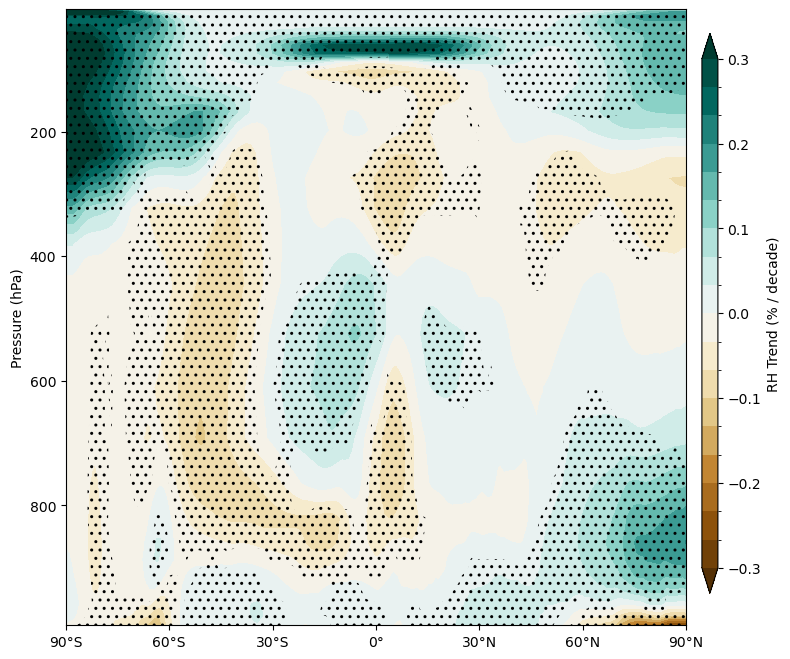

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [26]:
# Plot the zonal annual mean for all levels. Stippling shows where 95% of the models have the same sign
fig, ax = plt.subplots(1,1, figsize=(8,8))
cb = zonal_RH_annual_trend_mean.plot.contourf(ax=ax, x='latitude', y='level', add_colorbar=False, 
                                           levels=np.linspace(-0.3,0.3,19), extend='both', cmap='BrBG')
ax.contourf(zonal_RH_annual_trend_agreement.latitude, zonal_RH_annual_trend_agreement.level,
             zonal_RH_annual_trend_agreement.values, levels=[95,100], colors='none', hatches=['..'])

ax.invert_yaxis()
cax = plt.axes((0.92, 0.15, 0.02, 0.7))
cbar = plt.colorbar(cb, cax=cax, orientation='vertical', ticks=np.linspace(-0.3, 0.3, 7), 
                    label='RH Trend (% / decade)')
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('')
ax.set_xticks(np.arange(-90, 100, 30), ['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
plt.show()
plt.close


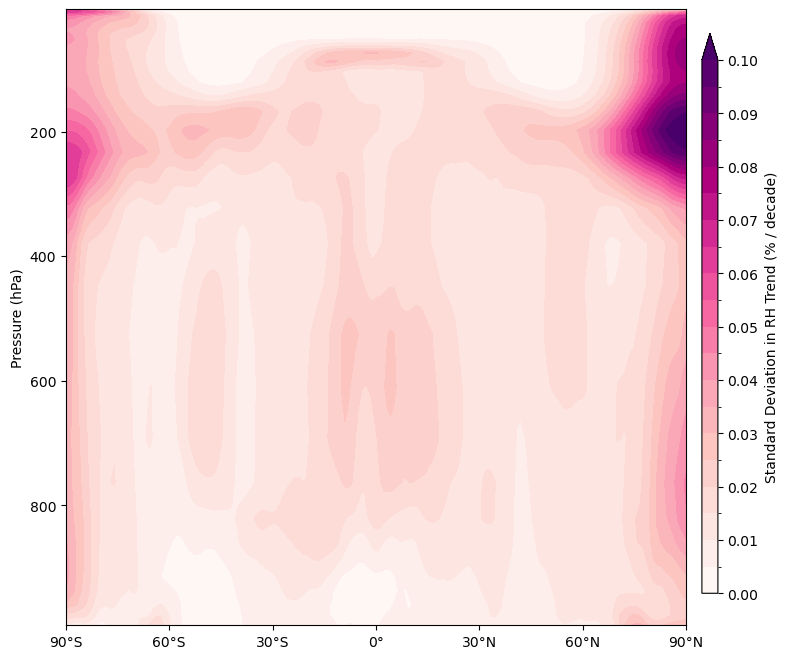

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [27]:
# Plot the standard deviation in the annual zonal RH across the 100 ensembles
fig, ax = plt.subplots(1,1, figsize=(8,8))
cb = zonal_RH_annual_trend_std.plot.contourf(x='latitude', y='level', add_colorbar=False, 
                                           levels=np.linspace(0,0.1,21), extend='max', cmap='RdPu')
ax.invert_yaxis()
cax = plt.axes((0.92, 0.15, 0.02, 0.7))
cbar = plt.colorbar(cb, cax=cax, orientation='vertical', ticks=np.linspace(0, 0.1, 11), 
                    label='Standard Deviation in RH Trend (% / decade)')
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('')
ax.set_xticks(np.arange(-90, 100, 30), ['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
plt.show()
plt.close

## Seasonal Means

In [28]:
# Repeat but treat each season (DJF, MAM, JJA, SON) separately

In [29]:
zonal_RH_seasonal_trend_all = xr.DataArray(dims=['latitude', 'level', 'ensemble', 'season'], coords=dict(latitude=RH_data_ex.latitude.data, 
                            level=RH_data_ex.level.data, ensemble=np.arange(1,101), season=np.arange(1,5,)))

for j in range(4):
    for i in range(len(ensembles)):
        if i < 50:
            model_str = cmip6_str
        else:
            model_str = smbb_str

        zonal_RH_seasonal = xr.open_dataset(str0 + str_zon + str1 + model_str + str2 + branch_years[i] + 
                                    str3 + ensembles[i] + str4 + season_strs[j] + str_zon2 + str5)['RELHUM']

        if len(zonal_RH_seasonal.time) == 165:

            zonal_RH_seasonal_trend = calc_trend(zonal_RH_seasonal)    

            zonal_RH_seasonal_trend_all[:,:,i,j] = zonal_RH_seasonal_trend.data

        else:
            print(model_str + str2 + branch_years[i] + str3 + ensembles[i])


In [30]:
zonal_RH_seasonal_trend_mean = zonal_RH_seasonal_trend_all.mean(dim='ensemble')
zonal_RH_seasonal_trend_std = zonal_RH_seasonal_trend_all.std(dim='ensemble')

In [31]:
pos_neg = np.zeros((len(RH_data_ex.latitude), len(RH_data_ex.level), 4))
for j in range(4):
    for i in range(100):
        pos_neg[:,:,j] += (zonal_RH_seasonal_trend_all.isel(ensemble=i, season=j) > 0)*2 - 1
    
    
zonal_RH_seasonal_trend_agreement = xr.DataArray(data=abs(pos_neg)/2+50, dims=['latitude', 'level', 'season'], coords=dict(latitude=zonal_RH_seasonal_trend.latitude.data, 
                            level=zonal_RH_seasonal_trend.level.data, season=np.arange(1,5))).transpose()

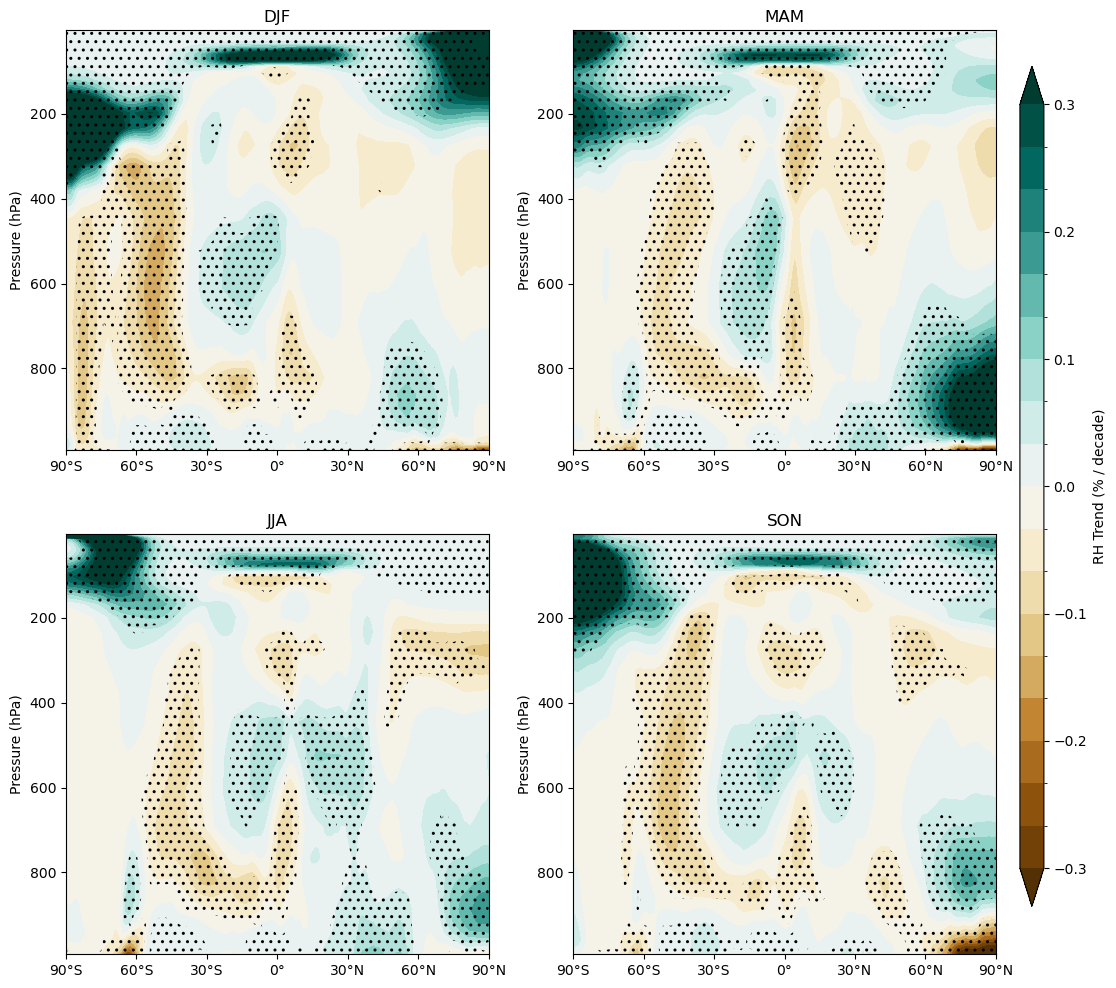

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,12))
axs = [ax1, ax2, ax3, ax4]

for i in range(4):

    cb = zonal_RH_seasonal_trend_mean.isel(season=i).plot.contourf(ax=axs[i], x='latitude', y='level', add_colorbar=False, 
                                               levels=np.linspace(-0.3,0.3,19), extend='both', cmap='BrBG')
    axs[i].contourf(zonal_RH_seasonal_trend_agreement.latitude, zonal_RH_seasonal_trend_agreement.level,
                 zonal_RH_seasonal_trend_agreement.isel(season=i).values, levels=[95,100], colors='none', hatches=['..'])

    axs[i].invert_yaxis()
    axs[i].set_ylabel('Pressure (hPa)')
    axs[i].set_xlabel('')
    axs[i].set_xticks(np.arange(-90, 100, 30), ['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
    axs[i].set_title(season_strs[i][:-1])

cax = plt.axes((0.92, 0.15, 0.02, 0.7))
cbar = plt.colorbar(cb, cax=cax, orientation='vertical', ticks=np.linspace(-0.3, 0.3, 7), 
                    label='RH Trend (% / decade)')
plt.show()
plt.close


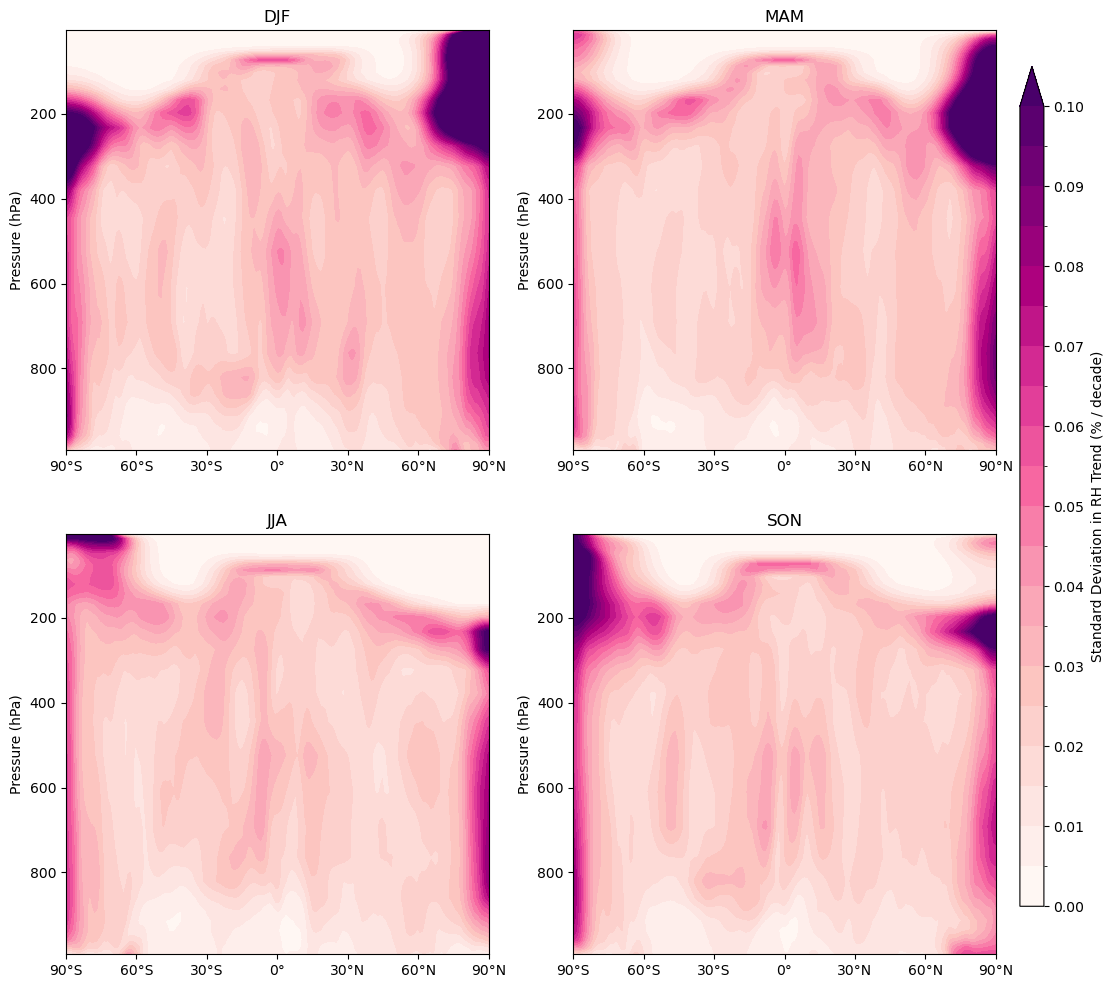

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,12))
axs = [ax1, ax2, ax3, ax4]

for i in range(4):

    cb = zonal_RH_seasonal_trend_std.isel(season=i).plot.contourf(ax=axs[i], x='latitude', y='level', add_colorbar=False, 
                                               levels=np.linspace(0,0.1,21), extend='max', cmap='RdPu')
    axs[i].invert_yaxis()
    axs[i].set_ylabel('Pressure (hPa)')
    axs[i].set_xlabel('')
    axs[i].set_xticks(np.arange(-90, 100, 30), ['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
    axs[i].set_title(season_strs[i][:-1])

cax = plt.axes((0.92, 0.15, 0.02, 0.7))
cbar = plt.colorbar(cb, cax=cax, orientation='vertical', ticks=np.linspace(0, 0.1, 11), 
                    label='Standard Deviation in RH Trend (% / decade)')
plt.show()
plt.close

# Tropical Mean

In [34]:
# Run the same code as before but for the tropical mean (30N-30S). This time the data has not latitude coordinate.

## Annual Mean

In [35]:
tropical_RH_annual_trend_all = xr.DataArray(dims=['level', 'ensemble'], coords=dict( 
                            level=RH_data_ex.level.data, ensemble=np.arange(1,101)))
for i in range(len(ensembles)):    
    if i < 50:
        model_str = cmip6_str
    else:
        model_str = smbb_str

    tropical_RH_annual = xr.open_dataset(str0 + str_trop + str1 + model_str + str2 + branch_years[i] + 
                                str3 + ensembles[i] + str4 + str_trop2 + str5)['RELHUM']
    
    if len(tropical_RH_annual.time) == 165:
    
        tropical_RH_annual_trend = calc_trend(tropical_RH_annual, lat=False)    
    
        tropical_RH_annual_trend_all[:,i] = tropical_RH_annual_trend.data
        
    else:
        print(model_str + str2 + branch_years[i] + str3 + ensembles[i])
            

In [36]:
# Also calculate the minimum and maximum of the RH trend
tropical_RH_annual_trend_mean = tropical_RH_annual_trend_all.mean(dim='ensemble')
tropical_RH_annual_trend_std = tropical_RH_annual_trend_all.std(dim='ensemble')
tropical_RH_annual_trend_min = tropical_RH_annual_trend_all.min(dim='ensemble')
tropical_RH_annual_trend_max = tropical_RH_annual_trend_all.max(dim='ensemble')

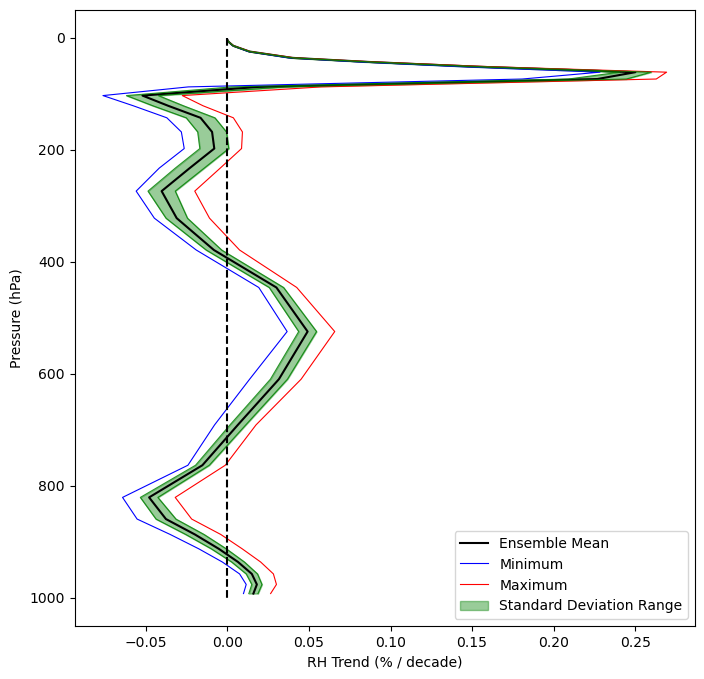

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
tropical_RH_annual_trend_mean.plot(ax=ax, y='level', c='k', label='Ensemble Mean')
tropical_RH_annual_trend_min.plot(ax=ax, y='level', c='b', lw=0.8, label='Minimum')
tropical_RH_annual_trend_max.plot(ax=ax, y='level', c='r', lw=0.8, label='Maximum')
(tropical_RH_annual_trend_mean+tropical_RH_annual_trend_std).plot(ax=ax, y='level', c='g', alpha=0.8, lw=0.8)
(tropical_RH_annual_trend_mean-tropical_RH_annual_trend_std).plot(ax=ax, y='level', c='g', alpha=0.8, lw=0.8)
plt.vlines(x=0, ymin=0, ymax=1000, color='k', ls='--')
plt.fill_betweenx(tropical_RH_annual_trend.level, x1=tropical_RH_annual_trend_mean-tropical_RH_annual_trend_std, x2=tropical_RH_annual_trend_mean+tropical_RH_annual_trend_std, alpha=0.4, color='g', label='Standard Deviation Range')


ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('RH Trend (% / decade)')
plt.legend()
plt.show()
plt.close

## Seasonal Means

In [38]:
tropical_RH_seasonal_trend_all = xr.DataArray(dims=['level', 'ensemble', 'season'], coords=dict( 
                            level=RH_data_ex.level.data, ensemble=np.arange(1,101), season=np.arange(1,5)))

for j in range(4):
    for i in range(len(ensembles)):    
        if i < 50:
            model_str = cmip6_str
        else:
            model_str = smbb_str

        tropical_RH_seasonal = xr.open_dataset(str0 + str_trop + str1 + model_str + str2 + branch_years[i] + 
                                    str3 + ensembles[i] + str4 + season_strs[j] + str_trop2 + str5)['RELHUM']

        if len(tropical_RH_seasonal.time) == 165:

            tropical_RH_seasonal_trend = calc_trend(tropical_RH_seasonal, lat=False)

            tropical_RH_seasonal_trend_all[:,i,j] = tropical_RH_seasonal_trend.data

        else:
            print(model_str + str2 + branch_years[i] + str3 + ensembles[i])


In [39]:
tropical_RH_seasonal_trend_mean = tropical_RH_seasonal_trend_all.mean(dim='ensemble')
tropical_RH_seasonal_trend_std = tropical_RH_seasonal_trend_all.std(dim='ensemble')
tropical_RH_seasonal_trend_min = tropical_RH_seasonal_trend_all.min(dim='ensemble')
tropical_RH_seasonal_trend_max = tropical_RH_seasonal_trend_all.max(dim='ensemble')

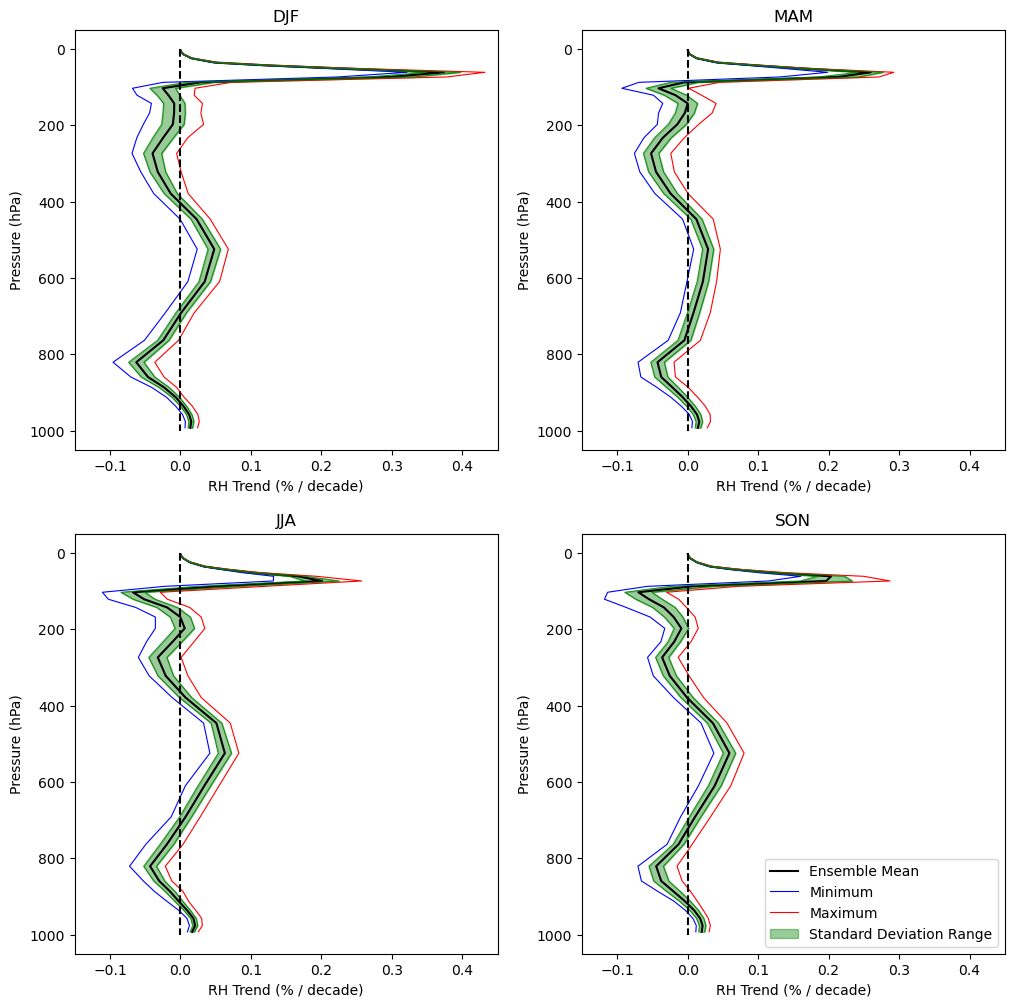

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
axs = [ax1, ax2, ax3, ax4]

for i in range(4):

    tropical_RH_seasonal_trend_mean.isel(season=i).plot(ax=axs[i], y='level', c='k', label='Ensemble Mean')
    tropical_RH_seasonal_trend_min.isel(season=i).plot(ax=axs[i], y='level', c='b', lw=0.8, label='Minimum')
    tropical_RH_seasonal_trend_max.isel(season=i).plot(ax=axs[i], y='level', c='r', lw=0.8, label='Maximum')
    (tropical_RH_seasonal_trend_mean+tropical_RH_seasonal_trend_std).isel(season=i).plot(ax=axs[i], y='level', c='g', alpha=0.8, lw=0.8)
    (tropical_RH_seasonal_trend_mean-tropical_RH_seasonal_trend_std).isel(season=i).plot(ax=axs[i], y='level', c='g', alpha=0.8, lw=0.8)
    axs[i].vlines(x=0, ymin=0, ymax=1000, color='k', ls='--')
    axs[i].fill_betweenx(tropical_RH_seasonal_trend.level, x1=tropical_RH_seasonal_trend_mean.isel(season=i)-tropical_RH_seasonal_trend_std.isel(season=i), 
                         x2=tropical_RH_seasonal_trend_mean.isel(season=i)+tropical_RH_seasonal_trend_std.isel(season=i), alpha=0.4, color='g', label='Standard Deviation Range')
    axs[i].invert_yaxis()
    axs[i].set_ylabel('Pressure (hPa)')
    axs[i].set_xlabel('RH Trend (% / decade)')
    axs[i].set_title(season_strs[i][:-1])
    axs[i].set_xlim(-0.15, 0.45)
    
plt.legend()
plt.show()
plt.close

# East Pacific Mean

In [41]:
# Repeat for the East Pacific (5S-25S, 140W-80W).

## Annual Mean

In [42]:
EP_RH_annual_trend_all = xr.DataArray(dims=['level', 'ensemble'], coords=dict( 
                            level=RH_data_ex.level.data, ensemble=np.arange(1,101)))
for i in range(len(ensembles)):    
    if i < 50:
        model_str = cmip6_str
    else:
        model_str = smbb_str

    EP_RH_annual = xr.open_dataset(str0 + str_EP + str1 + model_str + str2 + branch_years[i] + 
                                str3 + ensembles[i] + str4 + str_EP2 + str5)['RELHUM']
    
    if len(EP_RH_annual.time) == 165:
    
        EP_RH_annual_trend = calc_trend(EP_RH_annual, lat=False)    
    
        EP_RH_annual_trend_all[:,i] = EP_RH_annual_trend.data
        
    else:
        print(model_str + str2 + branch_years[i] + str3 + ensembles[i])
            

In [43]:
EP_RH_annual_trend_mean = EP_RH_annual_trend_all.mean(dim='ensemble')
EP_RH_annual_trend_std = EP_RH_annual_trend_all.std(dim='ensemble')
EP_RH_annual_trend_min = EP_RH_annual_trend_all.min(dim='ensemble')
EP_RH_annual_trend_max = EP_RH_annual_trend_all.max(dim='ensemble')

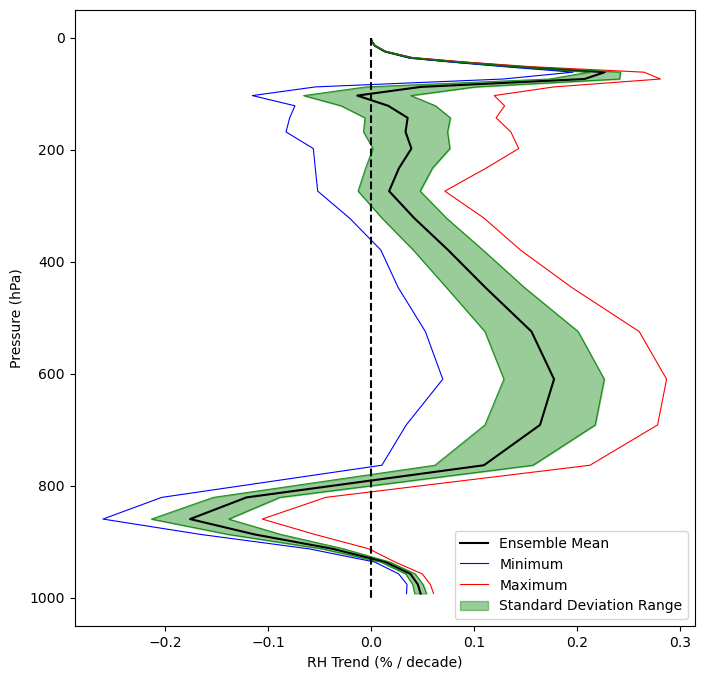

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [44]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
EP_RH_annual_trend_mean.plot(ax=ax, y='level', c='k', label='Ensemble Mean')
EP_RH_annual_trend_min.plot(ax=ax, y='level', c='b', lw=0.8, label='Minimum')
EP_RH_annual_trend_max.plot(ax=ax, y='level', c='r', lw=0.8, label='Maximum')
(EP_RH_annual_trend_mean+EP_RH_annual_trend_std).plot(ax=ax, y='level', c='g', alpha=0.8, lw=0.8)
(EP_RH_annual_trend_mean-EP_RH_annual_trend_std).plot(ax=ax, y='level', c='g', alpha=0.8, lw=0.8)
plt.vlines(x=0, ymin=0, ymax=1000, color='k', ls='--')
plt.fill_betweenx(EP_RH_annual_trend.level, x1=EP_RH_annual_trend_mean-EP_RH_annual_trend_std, x2=EP_RH_annual_trend_mean+EP_RH_annual_trend_std, alpha=0.4, color='g', label='Standard Deviation Range')

ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('RH Trend (% / decade)')
plt.legend()
plt.show()
plt.close

## Seasonal Means

In [45]:
EP_RH_seasonal_trend_all = xr.DataArray(dims=['level', 'ensemble', 'season'], coords=dict( 
                            level=RH_data_ex.level.data, ensemble=np.arange(1,101), season=np.arange(1,5)))

for j in range(4):
    for i in range(len(ensembles)):    
        if i < 50:
            model_str = cmip6_str
        else:
            model_str = smbb_str

        EP_RH_seasonal = xr.open_dataset(str0 + str_EP + str1 + model_str + str2 + branch_years[i] + 
                                    str3 + ensembles[i] + str4 + season_strs[j] + str_EP2 + str5)['RELHUM']

        if len(EP_RH_seasonal.time) == 165:

            EP_RH_seasonal_trend = calc_trend(EP_RH_seasonal, lat=False)

            EP_RH_seasonal_trend_all[:,i,j] = EP_RH_seasonal_trend.data

        else:
            print(model_str + str2 + branch_years[i] + str3 + ensembles[i])


In [46]:
EP_RH_seasonal_trend_mean = EP_RH_seasonal_trend_all.mean(dim='ensemble')
EP_RH_seasonal_trend_std = EP_RH_seasonal_trend_all.std(dim='ensemble')
EP_RH_seasonal_trend_min = EP_RH_seasonal_trend_all.min(dim='ensemble')
EP_RH_seasonal_trend_max = EP_RH_seasonal_trend_all.max(dim='ensemble')

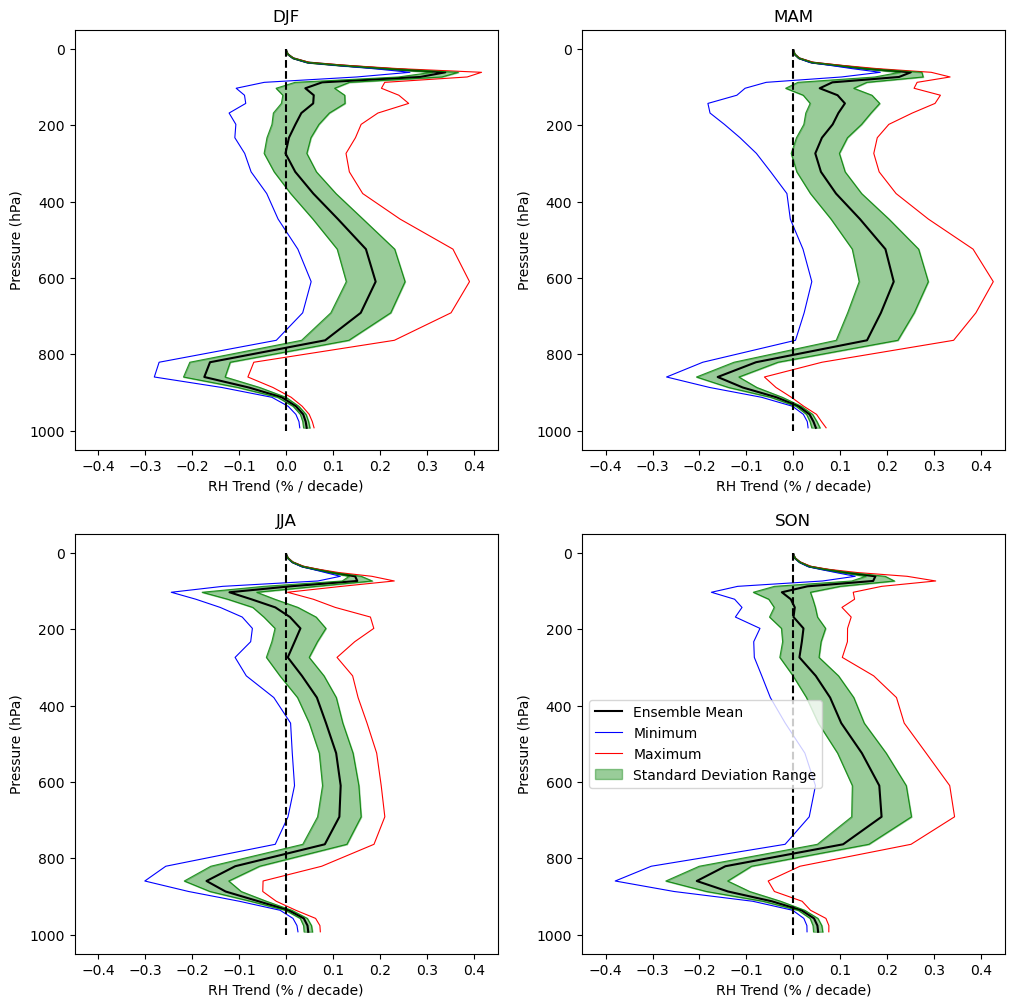

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [47]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
axs = [ax1, ax2, ax3, ax4]


for i in range(4):

    EP_RH_seasonal_trend_mean.isel(season=i).plot(ax=axs[i], y='level', c='k', label='Ensemble Mean')
    EP_RH_seasonal_trend_min.isel(season=i).plot(ax=axs[i], y='level', c='b', lw=0.8, label='Minimum')
    EP_RH_seasonal_trend_max.isel(season=i).plot(ax=axs[i], y='level', c='r', lw=0.8, label='Maximum')
    (EP_RH_seasonal_trend_mean+EP_RH_seasonal_trend_std).isel(season=i).plot(ax=axs[i], y='level', c='g', alpha=0.8, lw=0.8)
    (EP_RH_seasonal_trend_mean-EP_RH_seasonal_trend_std).isel(season=i).plot(ax=axs[i], y='level', c='g', alpha=0.8, lw=0.8)
    axs[i].vlines(x=0, ymin=0, ymax=1000, color='k', ls='--')
    axs[i].fill_betweenx(EP_RH_seasonal_trend.level, x1=EP_RH_seasonal_trend_mean.isel(season=i)-EP_RH_seasonal_trend_std.isel(season=i), 
                         x2=EP_RH_seasonal_trend_mean.isel(season=i)+EP_RH_seasonal_trend_std.isel(season=i), alpha=0.4, color='g', label='Standard Deviation Range')
    axs[i].invert_yaxis()
    axs[i].set_ylabel('Pressure (hPa)')
    axs[i].set_xlabel('RH Trend (% / decade)')
    axs[i].set_title(season_strs[i][:-1])
    axs[i].set_xlim(-0.45, 0.45)
    
plt.legend()
plt.show()
plt.close